# Assessment of vancomycin vs. another antibiotic

In clinical practice, the pertinent question is often not "should I use vancomycin?", but rather "should I use vancomycin or this other antibiotic?". This notebook aims to quantify the risk of nephrotoxicity when using vancomycin over the other antibiotic.


## Definitions

* **drug on admission:** patient received medication order -12 to 12 hours upon admission to the ICU
* **baseline creatinine:** first creatinine value between -12 to 12 hours upon admission to the ICU
* **AKI:** following KDIGO guidelines using only creatinine, any instance of AKI between 2-7 days after their ICU admission.

KDIGO guidelines for AKI are: >= 50% change from baseline over 7 days, or absolute increase of 0.3 in creatinine over 48 hours.

## 0. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2

# helper functions stored in local py file
import utils

# 1. Extract data and apply exclusions

For more detail on exclusions, see the main vancomycin analysis notebook.

In [2]:
# cohort with exclusions applied
co = pd.read_csv('data/cohort.csv.gz')

# covariates from APACHE table
dem = pd.read_csv('data/demographics.csv.gz')

# abx drug doses
va = pd.read_csv('data/vanco.csv.gz')
ce = pd.read_csv('data/cefepime.csv.gz')
zo = pd.read_csv('data/zosyn.csv.gz')
aki = pd.read_csv('data/aki.csv.gz')

# APACHE
apache = pd.read_csv('data/apache.csv.gz')

# convert apache predictions into numeric
apache['apache_prob'] = pd.to_numeric(apache['apache_prob'])

# sepsis/infection/organ failure
dx = pd.read_csv('data/sepsis_infection.csv.gz')

## Merge data

The antibiotic administration data extracted above has all administrations from time 0.
Thus, three dataframes need to be extracted before we can merge data:

1. Extract vanco_adm and vanco_wk
2. Extract cefepime_adm and cefepime_wk
3. Extract zosyn_adm and zosyn_wk

In [3]:
dem.head()

,patientunitstayid,unitdischargeoffset,age,gender,ethnicity,weight,height,bmi,bmi_group,apachescore,apache_group
0,1,1607,43,Female,Caucasian,61.11,162.5,23.0,normal,23.0,21-30
1,2,9855,65,Male,Caucasian,99.70,182.8,30.0,overweight,74.0,71-80
2,3,217,61,Female,Caucasian,NaN,NaN,NaN,NaN,NaN,NaN
3,4,709,61,Female,Caucasian,NaN,NaN,NaN,NaN,72.0,71-80
4,5,820,58,Male,African American,88.60,183.0,26.0,overweight,14.0,11-20


In [4]:
va.head()

,patientunitstayid,drugstartoffset,drugstopoffset,drugorderoffset,frequency,classification,dosage
0,9,341,399.0,345,STAT,once,1750 MG
1,9,370,519.0,343,ONE,once,1 EA
2,9,850,2312.0,439,NQ8H,NaN,1250 MG
3,20,-3,146.0,21,ONE,once,1 EA
4,20,177,206.0,101,STAT,once,1750 MG


In [5]:
v_df = utils.extract_adm_and_wk(va, 'vanco')
c_df = utils.extract_adm_and_wk(ce, 'cefepime')
z_df = utils.extract_adm_and_wk(zo, 'zosyn')

v_df.head()

,vanco_adm,vanco_wk
patientunitstayid,,
9,1,0
20,1,1
23,1,1
30,0,0
36,0,0


In [6]:
pd.crosstab(v_df['vanco_adm'], v_df['vanco_wk'])

vanco_wk,0,1
vanco_adm,,
0,69069,123395
1,160428,135064


In [7]:
# density of vancomycin administration over time
xi = np.arange(-12*60, 168*60)

vanco_administration = np.zeros([v_df.shape[0], ])

Repeat the above for NSAIDs/loop diuretics.

## Apply exclusions and create final dataframe

In [8]:
df = utils.prepare_dataframe(co, dem, aki, apache, dx, drug_dfs=[v_df, c_df, z_df])

print('{} patients.'.format(df.shape[0]))

print('Antibiotic use on admission to ICU:')
for abx in ['vanco', 'cefepime', 'zosyn']:
    N = df[abx + '_adm'].sum()
    mu = N/df.shape[0]*100.0
    print(f'  {N:5d} ({mu:4.1f}%) - {abx}')
    
    
print('\nConcurrent antibiotic use:')
for abx1, abx2 in [['vanco', 'cefepime'], ['vanco', 'zosyn']]:
    N = ((df[abx1 + '_adm'] == 1) & (df[abx2 + '_adm'] == 1)).sum()
    mu = N/df.shape[0]*100.0
    print(f'  {N:5d} ({mu:4.1f}%) - {abx1} & {abx2}')
    
df.head()

262498 patients.
Antibiotic use on admission to ICU:
  42673 (16.3%) - vanco
   8228 ( 3.1%) - cefepime
  37366 (14.2%) - zosyn

Concurrent antibiotic use:
   4915 ( 1.9%) - vanco & cefepime
  21442 ( 8.2%) - vanco & zosyn


,unitdischargeoffset,age,gender,ethnicity,weight_kg,height_cm,bmi,bmi_group,apachescore,apache_group,...,organfailure,infection_skin_soft_tissue,sepsis,egfr,vanco_adm,vanco_wk,cefepime_adm,cefepime_wk,zosyn_adm,zosyn_wk
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
141139,4332,50,Male,Caucasian,111.27,193.0,30.0,overweight,34.0,31-40,...,0,no,no,75.594581,0,0,0,0,0,0
141144,10014,65,Female,Caucasian,102.71,167.6,37.0,overweight,48.0,41-50,...,1,no,no,62.838338,0,0,0,0,0,0
141151,4313,67,Male,Caucasian,86.05,172.5,29.0,overweight,52.0,51-60,...,0,no,no,19.756316,0,0,0,0,0,0
141156,1189,90,Male,Caucasian,76.10,172.7,26.0,overweight,49.0,41-50,...,0,no,no,56.878962,0,0,0,0,0,0
141159,4595,61,Male,African American,63.91,170.2,22.0,normal,55.0,51-60,...,0,no,no,138.955446,0,0,0,0,0,0


# Define the comparisons

We will perform a number of comparisons between patient groups selected based upon the drugs they were exposed to.
In order to make these comparisons clear, we'll define all the groups upfront, then later run the comparisons.

Define the dataframes used for 

1. vanco + zosyn vs. vanco + cefepime
2. vanco + zosyn vs vanco
3. vanco + cefepime vs vanco

In [9]:
from collections import OrderedDict
comparisons = OrderedDict()

idxCefepime = (df['cefepime_adm'] == 1) & (df['cefepime_wk'] == 1)
idxZosyn = (df['zosyn_adm'] == 1) & (df['zosyn_wk'] == 1)
idxVanco = (df['vanco_adm'] == 1) & (df['vanco_wk'] == 1)

# Vanco + Zosyn vs Vanco + Cefepime
comparisons['v+z (exp) vs v+c (ctl)'] = {
    'exposure': df[idxVanco & idxZosyn & ~idxCefepime],
    'control': df[idxVanco & ~idxZosyn & idxCefepime],
    'covariates': [
        'age', 'apache_prob', 'sepsis', 'immunocompromised', 'egfr'
    ],
    'seed': 842
}

# Vanco + Zosyn vs Vanco
comparisons['v+z (exp) vs v (ctl)'] = {
    'exposure': df[idxVanco & idxZosyn & ~idxCefepime],
    'control': df[idxVanco & ~idxZosyn & ~idxCefepime],
    'covariates': [
        'age', 'apache_prob', 'sepsis', 'infection_skin_soft_tissue', 'immunocompromised', 'egfr'
    ],
    'seed': 5513
}

# Vanco + Cefepime vs Vanco
comparisons['v+c (exp) vs v (ctl)'] = {
    'exposure': df[idxVanco & ~idxZosyn & idxCefepime],
    'control': df[idxVanco & ~idxZosyn & ~idxCefepime],
    'covariates': [
        'age', 'apache_prob', 'sepsis', 'infection_skin_soft_tissue', 'immunocompromised', 'egfr'
    ],
    'seed': 543289
}

## Propensity score comparisons

With the datasets defined, we can run the comparisons which match patient severity of illness using the APACHE-IV score.

In [10]:
propensity_scores = {}

for k, v in comparisons.items():
    print(f'=========\n\n{k}\n')
    propensity_scores[k] = utils.propensity_match(**v)
    
    cm = utils.get_contingency_tables(propensity_scores[k], outcome_var='aki')
    
    
    pval, R, ci = utils.cmh_test(cm, alpha=0.05)
    pval_str = f'= {pval:1.3f}' if pval > 0.001 else '< 0.001'
    print(f'{k}: p {pval_str}. {R:3.2f} [{ci[0]:3.2f} - {ci[1]:3.2f}].')
    print('\n\n=========')

Column ethnicity missing 44 observations in exposure dataframe.
Column ethnicity missing 11 observations in control dataframe.
Column weight_kg missing 61 observations in exposure dataframe.
Column weight_kg missing 10 observations in control dataframe.
Column height_cm missing 177 observations in exposure dataframe.
Column height_cm missing 36 observations in control dataframe.
Column bmi missing 213 observations in exposure dataframe.
Column bmi missing 43 observations in control dataframe.
Column bmi_group missing 213 observations in exposure dataframe.
Column bmi_group missing 43 observations in control dataframe.



v+z (exp) vs v+c (ctl)

Formula:
status ~ age+apache_prob+immunocompromised+sepsis+egfr
n majority: 9379
n minority: 1913
Fitting 1 (Unbalanced) Model...

Accuracy 83.06


/home/alistairewj/miniconda3/envs/vanco-renal-toxicity/lib/python3.7/site-packages/pymatch/Matcher.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.matched_data['match_id'] = match_ids
/home/alistairewj/miniconda3/envs/vanco-renal-toxicity/lib/python3.7/site-packages/pymatch/Matcher.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.matched_data['record_id'] = self.matched_data.index
Column ethnicity missing 44 observations in exposure dataframe.
Column ethnicity missing 59 observations in control dataframe.
Column weight_

v+z (exp) vs v+c (ctl): p < 0.001. 1.31 [1.17 - 1.47].



v+z (exp) vs v (ctl)

Formula:
status ~ age+apache_prob+immunocompromised+infection_skin_soft_tissue+sepsis+egfr
n majority: 12477
n minority: 9379
Fitting 1 (Unbalanced) Model...

Accuracy 57.17


Column ethnicity missing 11 observations in exposure dataframe.
Column ethnicity missing 59 observations in control dataframe.
Column weight_kg missing 10 observations in exposure dataframe.
Column weight_kg missing 105 observations in control dataframe.
Column height_cm missing 36 observations in exposure dataframe.
Column height_cm missing 294 observations in control dataframe.
Column bmi missing 43 observations in exposure dataframe.
Column bmi missing 351 observations in control dataframe.
Column bmi_group missing 43 observations in exposure dataframe.
Column bmi_group missing 351 observations in control dataframe.


v+z (exp) vs v (ctl): p = 0.010. 1.08 [1.02 - 1.15].



v+c (exp) vs v (ctl)

Formula:
status ~ age+apache_prob+immunocompromised+infection_skin_soft_tissue+sepsis+egfr
n majority: 12477
n minority: 1913
Fitting 1 (Unbalanced) Model...

Accuracy 86.71
v+c (exp) vs v (ctl): p = 0.003. 0.81 [0.71 - 0.93].




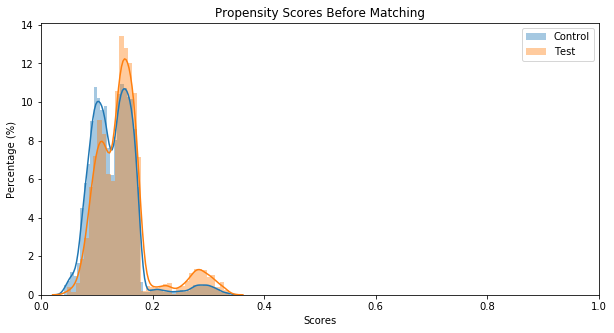

In [12]:
propensity_scores['v+c (exp) vs v (ctl)'].plot_scores()

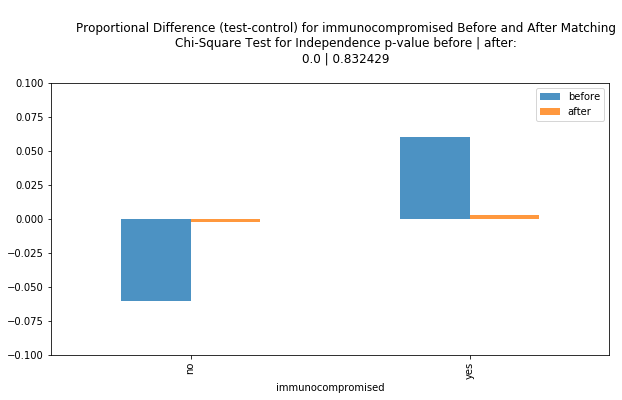

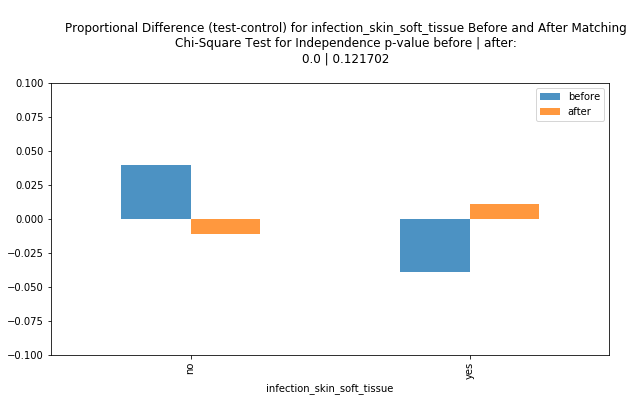

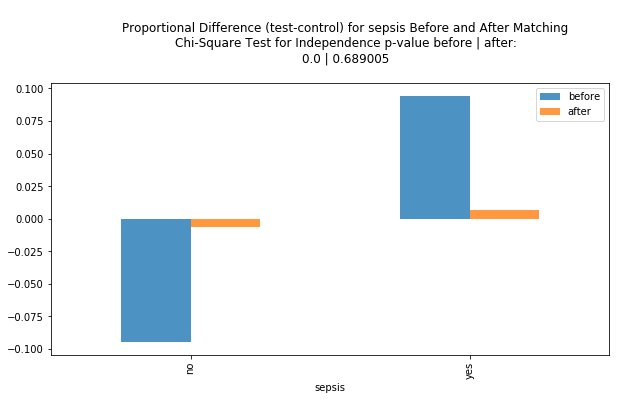

In [13]:
propensity_scores['v+c (exp) vs v (ctl)'].compare_categorical()

In [11]:

"""
# Helper function to read data from database
conn_info = "host='localhost' dbname='eicu' user='alistairewj' port=5647"
con = psycopg2.connect(conn_info)

def run_query(query, con=con):
    return pd.read_sql_query(query, con)

yr = run_query('select patientunitstayid, hospitalDischargeYear from eicu_full_phi.patient')
yr.head()
df = df.merge(yr, left_index=True, right_on='patientunitstayid', how='left')

yr_grp = df.groupby('hospitaldischargeyear')[['vanco_adm', 'cefepime_adm', 'zosyn_adm']].mean()
plt.figure()
plt.plot(yr_grp*100)
plt.legend(yr_grp.columns)
plt.show()
"""

'\n# Helper function to read data from database\nconn_info = "host=\'localhost\' dbname=\'eicu\' user=\'alistairewj\' port=5647"\ncon = psycopg2.connect(conn_info)\n\ndef run_query(query, con=con):\n    return pd.read_sql_query(query, con)\n\nyr = run_query(\'select patientunitstayid, hospitalDischargeYear from eicu_full_phi.patient\')\nyr.head()\ndf = df.merge(yr, left_index=True, right_on=\'patientunitstayid\', how=\'left\')\n\nyr_grp = df.groupby(\'hospitaldischargeyear\')[[\'vanco_adm\', \'cefepime_adm\', \'zosyn_adm\']].mean()\nplt.figure()\nplt.plot(yr_grp*100)\nplt.legend(yr_grp.columns)\nplt.show()\n'